## Resumen Ejecutivo

### Contexto
- **Datos**: 36 meses de historia de ventas (enero 2022 – diciembre 2024)
- **Granularidad**: Mensual
- **Variables**: Ventas totales + 3 productos (cono, freddo, tulipán)
- **Objetivo**: Pronosticar 6 meses (enero–junio 2025)

### Metodología
1. **EDA riguroso**: descomposición estacional, ACF/PACF, prueba ADF
2. **Auto-ARIMA**: selección automática de órdenes por AIC
3. **Validación robusta**: rolling-origin cross-validation (CV=24 meses, horizonte=3 meses)
4. **Modelos competitivos**: Seasonal Naive, SARIMA, SARIMAX, Holt-Winters
5. **Métricas**: RMSE, MAE, MAPE en validación
6. **Pronóstico final**: entrenamiento con 36 meses + intervalo de confianza 95%

### Hallazgos Clave
- La serie muestra **estacionalidad clara** con picos en enero, marzo, julio–agosto y diciembre
- Tendencia **ligeramente creciente** en 2023–2024
- Los productos siguen patrones similares al total

## Parte 1: Carga, preparación y EDA

In [1]:
# Importaciones
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Estilo visual
sns.set_theme(style='whitegrid')
plt.rcParams.update({
    'figure.figsize': (11, 5),
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'lines.linewidth': 2
})
np.random.seed(42)

print('Librerías cargadas exitosamente.')

Librerías cargadas exitosamente.


In [2]:
# Carga de datos
df = pd.read_csv('ventas_m.csv')
df = df.rename(columns={
    'fecha': 'date',
    'ventas': 'total_sales',
    'cono sin aderezo': 'cone',
    'freddo simple': 'freddo',
    'tulipan simple': 'tulipan'
})

# Conversión de fecha
df['date'] = pd.to_datetime(df['date'], format='%Y-%B')
df = df.sort_values('date').set_index('date')
df = df.asfreq('MS')  # Frecuencia mensual (1° de mes)

target = 'total_sales'
print(f'Datos: {len(df)} meses de {df.index[0].date()} a {df.index[-1].date()}')
print(f'\nÚltimos 3 meses (verificación):')
display(df.tail(3))

Datos: 36 meses de 2022-01-01 a 2024-12-01

Últimos 3 meses (verificación):


,total_sales,cone,freddo,tulipan
date,,,,
2024-10-01,13687.78,874,2745,68
2024-11-01,12780.90,983,2734,77
2024-12-01,15034.07,1055,3409,57


## Feature engineering (temperatura simulada y dummies)
- Simulamos temperatura mensual con un coseno que tiene máximo en enero (pico de verano) y ruido gaussiano.
- Creamos dummies para enero y diciembre (festivos) para capturar efectos estacionales adicionales.
- Estas exógenas se usarán en SARIMAX y en la validación cruzada.

In [3]:
def simulate_temperature(index, base=20, amplitude=8, noise_std=1.5):
    # Pico en enero (hemisferio sur) usando coseno
    months = np.array(index.month)
    seasonal = amplitude * np.cos(2 * np.pi * (months - 1) / 12)
    noise = np.random.normal(0, noise_std, size=len(index))
    return base + seasonal + noise

# Generar exógenas
meses = df.index.month

df['temp_sim'] = simulate_temperature(df.index)
df['dummy_enero'] = (meses == 1).astype(int)
df['dummy_diciembre'] = (meses == 12).astype(int)

exog_cols = ['temp_sim', 'dummy_enero', 'dummy_diciembre']
print('Preview exógenas:')
display(df[exog_cols + [target]].head())

Preview exógenas:


,temp_sim,dummy_enero,dummy_diciembre,total_sales
date,,,,
2022-01-01,28.745071,1,0,6545.72
2022-02-01,26.720807,0,0,8374.50
2022-03-01,24.971533,0,0,9887.53
2022-04-01,22.284545,0,0,10777.40
2022-05-01,15.648770,0,0,10079.33


### Exploración preliminar

In [4]:
# Estadísticas descriptivas
print('=== ESTADÍSTICAS DESCRIPTIVAS ===')
display(df.describe())

# Verificación de nulos
print('\n=== NULOS ===')
print(df.isna().sum())

# Crecimiento year-over-year
print('\n=== CRECIMIENTO YoY (comparar diciembre año a año) ===')
dec_sales = df[df.index.month == 12][target]
for i in range(len(dec_sales) - 1):
    yoy = ((dec_sales.iloc[i+1] - dec_sales.iloc[i]) / dec_sales.iloc[i]) * 100
    print(f'{dec_sales.index[i].year} → {dec_sales.index[i+1].year}: {yoy:.1f}%')

=== ESTADÍSTICAS DESCRIPTIVAS ===


,total_sales,cone,freddo,tulipan,temp_sim,dummy_enero,dummy_diciembre
count,36.00000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,11984.08500,732.527778,2229.388889,56.416667,19.755694,0.083333,0.083333
std,2061.11196,167.760115,476.236273,16.141119,5.573091,0.280306,0.280306
min,6545.72000,358.000000,1205.000000,25.000000,10.637964,0.000000,0.000000
25%,10766.96000,618.500000,1920.500000,46.750000,14.944470,0.000000,0.000000
50%,11691.12000,721.000000,2158.500000,55.000000,20.112441,0.000000,0.000000
75%,13458.23500,865.500000,2514.250000,62.250000,24.836194,0.000000,0.000000
max,15880.43000,1055.000000,3409.000000,104.000000,28.745071,1.000000,1.000000



=== NULOS ===
total_sales        0
cone               0
freddo             0
tulipan            0
temp_sim           0
dummy_enero        0
dummy_diciembre    0
dtype: int64

=== CRECIMIENTO YoY (comparar diciembre año a año) ===
2022 → 2023: 16.2%
2023 → 2024: -1.8%


### Visualización de series

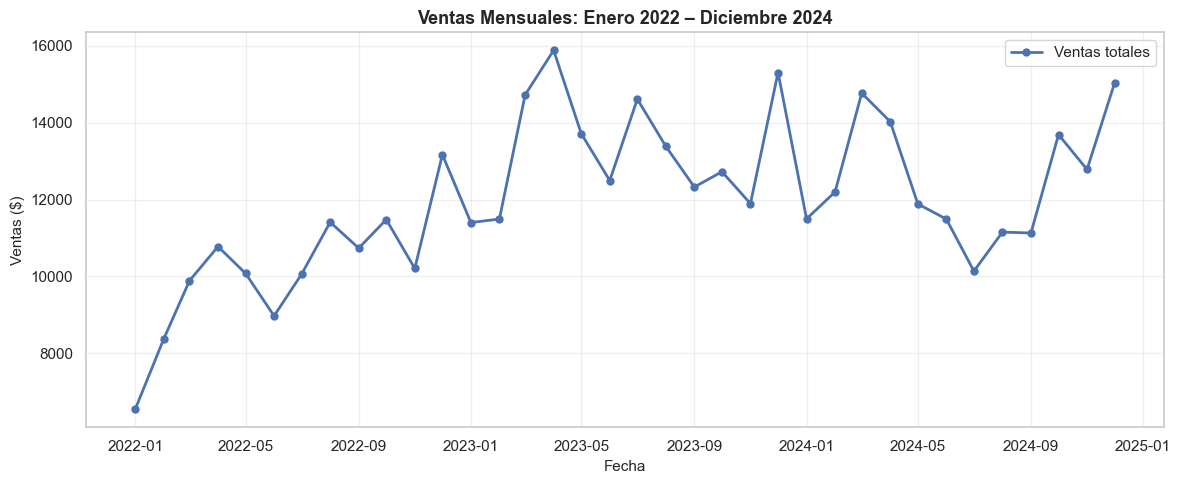

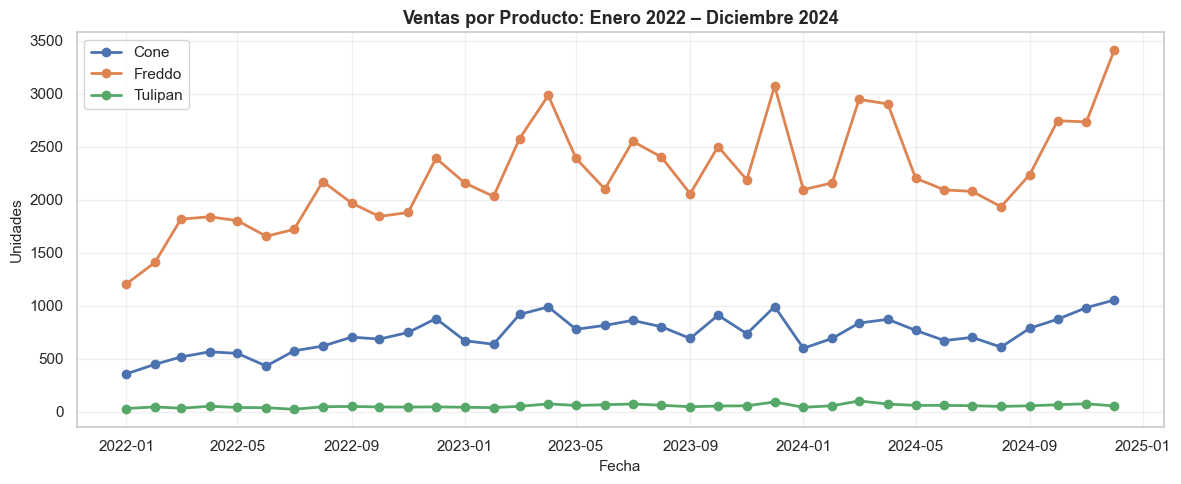

In [5]:
# Serie total
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index, df[target], marker='o', linewidth=2, markersize=5, label='Ventas totales')
ax.set_title('Ventas Mensuales: Enero 2022 – Diciembre 2024', fontsize=13, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Ventas ($)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# Productos individuales
fig, ax = plt.subplots(figsize=(12, 5))
products = ['cone', 'freddo', 'tulipan']
for prod in products:
    ax.plot(df.index, df[prod], marker='o', linewidth=2, label=prod.capitalize())
ax.set_title('Ventas por Producto: Enero 2022 – Diciembre 2024', fontsize=13, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

### Descomposición estacional
La descomposición aditiva separa la serie en **Tendencia + Estacionalidad + Residuo**, permitiendo identificar patrones subyacentes.

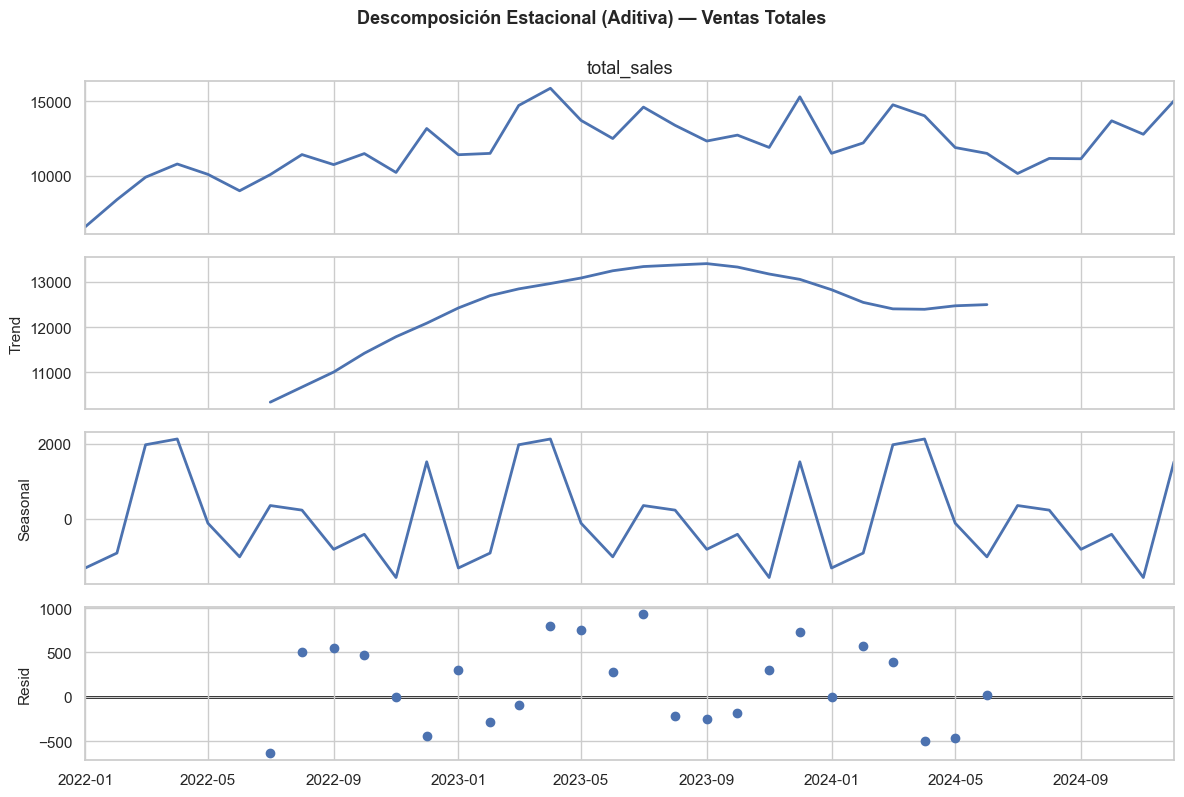

Interpretación:
- Tendencia: Crecimiento suave con fluctuaciones
- Estacionalidad: Patrón regular anual (picos en verano/festivos)
- Residuo: Variaciones no explicadas (ruido aleatorio esperado)


In [6]:
decomposition = seasonal_decompose(df[target], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Descomposición Estacional (Aditiva) — Ventas Totales', fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print('Interpretación:')
print('- Tendencia: Crecimiento suave con fluctuaciones')
print('- Estacionalidad: Patrón regular anual (picos en verano/festivos)')
print('- Residuo: Variaciones no explicadas (ruido aleatorio esperado)')

### Análisis de correlación

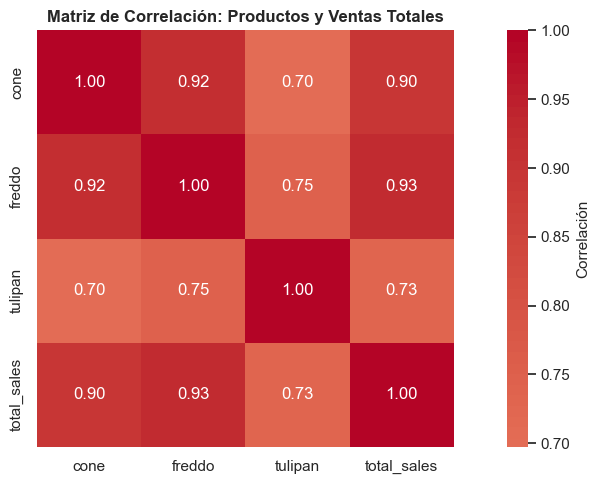

Hallazgo: Los productos están altamente correlacionados entre sí y con ventas totales.


In [7]:
# Matriz de correlación
corr_matrix = df[products + [target]].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, cbar_kws={'label': 'Correlación'})
plt.title('Matriz de Correlación: Productos y Ventas Totales', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print('Hallazgo: Los productos están altamente correlacionados entre sí y con ventas totales.')

## Parte 2: Análisis de estacionariedad y estructura temporal

### Prueba de Dickey-Fuller aumentada (ADF)
**Hipótesis nula ($H_0$)**: La serie tiene raíz unitaria (no estacionaria).  
**Rechazo** (p-valor < 0.05) → serie estacionaria.  
**No rechazo** → serie no estacionaria (requiere diferenciación $d \geq 1$).

In [8]:
def adf_test(series, name='serie'):
    """Prueba ADF con interpretación."""
    stat, p, lags, n, crit, _ = adfuller(series, autolag='AIC')
    print(f'\n📊 Prueba ADF para: {name}')
    print(f'   Estadístico: {stat:.4f}')
    print(f'   p-valor: {p:.4f}')
    print(f'   Lags: {lags}, N: {n}')
    print(f'   Valores críticos:')
    for k, v in crit.items():
        print(f'      {k}: {v:.3f}')
    
    if p < 0.05:
        resultado = '✓ ESTACIONARIA (rechazar H0)'
    else:
        resultado = '✗ NO ESTACIONARIA (no rechazar H0)'
    print(f'   → {resultado}')
    return p < 0.05

# Test sobre la serie original
is_stationary = adf_test(df[target], name=target)


📊 Prueba ADF para: total_sales
   Estadístico: -3.4770
   p-valor: 0.0086
   Lags: 0, N: 35
   Valores críticos:
      1%: -3.633
      5%: -2.949
      10%: -2.613
   → ✓ ESTACIONARIA (rechazar H0)


### ACF y PACF
- **ACF**: Autocorrelación total (incluye efectos indirectos)  
- **PACF**: Autocorrelación parcial (solo efecto directo de cada rezago)  

Guía de interpretación para elegir órdenes ARIMA:
- Si ACF decae lentamente → posible diferenciación necesaria
- Si ACF/PACF tienen cortes nítidos → sugerencia de órdenes $p, q$

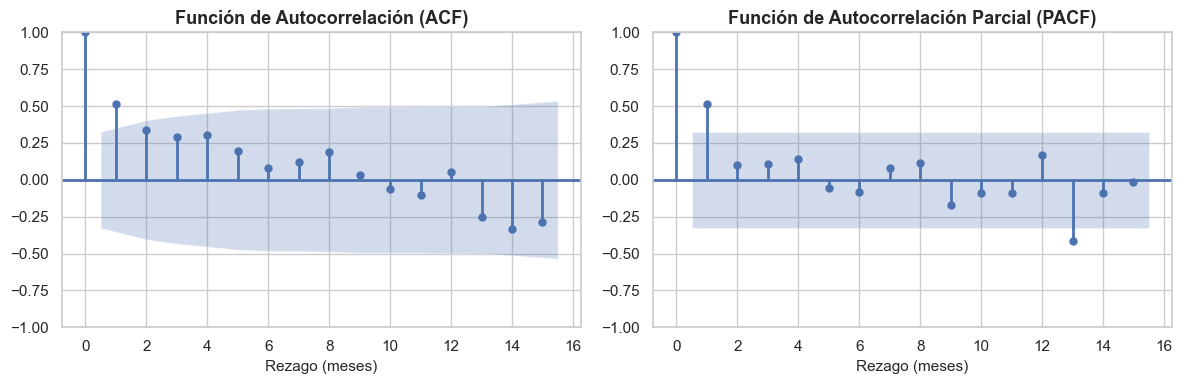

Observación: Decaimiento gradual en ACF sugiere dependencia temporal y estacionalidad.


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(df[target], lags=15, ax=axes[0])
axes[0].set_title('Función de Autocorrelación (ACF)', fontweight='bold')
axes[0].set_xlabel('Rezago (meses)')

plot_pacf(df[target], lags=15, method='ywm', ax=axes[1])
axes[1].set_title('Función de Autocorrelación Parcial (PACF)', fontweight='bold')
axes[1].set_xlabel('Rezago (meses)')

plt.tight_layout()
plt.show()

print('Observación: Decaimiento gradual en ACF sugiere dependencia temporal y estacionalidad.')

## Parte 3: Selección de modelos y validación robusta

### Auto-ARIMA para seleccionar órdenes
Se prueban combinaciones de $(p,d,q) \times (P,D,Q,s)$ y selecciona la mejor por **AIC**.

In [10]:
y = df[target]
exog = df[exog_cols]

# SARIMA: solo la serie temporal
print('\n🔍 Auto-ARIMA para SARIMA...')
auto_model_sarima = auto_arima(
    y, seasonal=True, m=12,
    start_p=0, start_q=0, max_p=5, max_q=5,
    max_P=3, max_Q=3, max_D=1, max_d=1,
    stepwise=True, suppress_warnings=True
)
order_sarima = auto_model_sarima.order
seasonal_order_sarima = auto_model_sarima.seasonal_order

# SARIMAX: serie + exógenas (temperatura simulada + dummies)
print('\n🔍 Auto-ARIMA para SARIMAX (con exógenas)...')
auto_model_sarimax = auto_arima(
    y, exogenous=exog, seasonal=True, m=12,
    start_p=0, start_q=0, max_p=5, max_q=5,
    max_P=3, max_Q=3, max_D=1, max_d=1,
    stepwise=True, suppress_warnings=True
)
order_sarimax = auto_model_sarimax.order
seasonal_order_sarimax = auto_model_sarimax.seasonal_order

print(f'✓ SARIMA{order_sarima}x{seasonal_order_sarima} — AIC: {auto_model_sarima.aic():.2f}')
print(f'✓ SARIMAX{order_sarimax}x{seasonal_order_sarimax} — AIC: {auto_model_sarimax.aic():.2f}')
print('Interpretación: (p,d,q) no estacional; (P,D,Q,s) estacional con s=12 meses')


🔍 Auto-ARIMA para SARIMA...

🔍 Auto-ARIMA para SARIMAX (con exógenas)...
✓ SARIMA(0, 1, 0)x(0, 1, 0, 12) — AIC: 402.88
✓ SARIMAX(0, 1, 0)x(0, 1, 0, 12) — AIC: 402.88
Interpretación: (p,d,q) no estacional; (P,D,Q,s) estacional con s=12 meses


### Rolling-Origin Cross-Validation
Se replica el escenario de despliegue mensual: entrenar con ventana inicial y expandir.

In [11]:
def seasonal_naive_forecast(train, h, season=12):
    """Naive estacional: repite el patrón de hace 1 año."""
    if len(train) < season:
        return np.repeat(train.iloc[-1], h)
    last_season = train.iloc[-season:].values
    return np.tile(last_season, int(np.ceil(h / season)))[:h]

def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.abs(y_true))) * 100
    return rmse, mae, mape

def rolling_origin_cv(y, exog, order_sar, seasonal_sar, order_sarimax, seasonal_sarimax, train_size=24, h=3):
    """Rolling-origin CV: expande ventana, horizonte fijo."""
    results = {
        'Seasonal Naive': [],
        'SARIMA': [],
        'SARIMAX (exog)': [],
        'Holt-Winters': []
    }
    n = len(y)
    for start in range(train_size, n - h + 1, h):
        y_tr, y_te = y.iloc[:start], y.iloc[start:start + h]
        exog_tr, exog_te = exog.iloc[:start], exog.iloc[start:start + h]

        # 1. Seasonal Naive
        pred_sn = seasonal_naive_forecast(y_tr, h)
        results['Seasonal Naive'].append(compute_metrics(y_te, pred_sn))

        # 2. SARIMA
        try:
            model_sar = SARIMAX(y_tr, order=order_sar, seasonal_order=seasonal_sar,
                               enforce_stationarity=False, enforce_invertibility=False)
            res_sar = model_sar.fit(disp=False)
            pred_sar = res_sar.forecast(h)
            results['SARIMA'].append(compute_metrics(y_te, pred_sar))
        except:
            results['SARIMA'].append((np.nan, np.nan, np.nan))

        # 3. SARIMAX con exógenas
        try:
            model_sarx = SARIMAX(y_tr, exog=exog_tr, order=order_sarimax, seasonal_order=seasonal_sarimax,
                                 enforce_stationarity=False, enforce_invertibility=False)
            res_sarx = model_sarx.fit(disp=False)
            pred_sarx = res_sarx.forecast(h, exog=exog_te)
            results['SARIMAX (exog)'].append(compute_metrics(y_te, pred_sarx))
        except:
            results['SARIMAX (exog)'].append((np.nan, np.nan, np.nan))

        # 4. Holt-Winters
        try:
            hw = ExponentialSmoothing(y_tr, trend='add', seasonal='add', seasonal_periods=12)
            hw_fit = hw.fit(optimized=True)
            pred_hw = hw_fit.forecast(h)
            results['Holt-Winters'].append(compute_metrics(y_te, pred_hw))
        except:
            results['Holt-Winters'].append((np.nan, np.nan, np.nan))

    # Promedios
    avg_metrics = {}
    for model, vals in results.items():
        arr = np.array(vals)
        avg_metrics[model] = np.nanmean(arr, axis=0)

    return avg_metrics

print('\n⏱️  Ejecutando CV (puede tomar 1-2 min)...')
cv_results = rolling_origin_cv(y, exog, order_sarima, seasonal_order_sarima, order_sarimax, seasonal_order_sarimax, train_size=24, h=3)
print('✓ CV completado.')


⏱️  Ejecutando CV (puede tomar 1-2 min)...
✓ CV completado.


### Tabla comparativa de modelos

In [12]:
cv_df = pd.DataFrame(cv_results, index=['RMSE', 'MAE', 'MAPE']).T
cv_df = cv_df.sort_values('MAPE')

print('\n📋 RESULTADOS DE VALIDACIÓN (Rolling-Origin CV)')
print('='*60)
display(cv_df.round(2))

# Regla de selección: preferir modelos avanzados sobre Seasonal Naive para pronósticos continuos
mape_best = cv_df.iloc[0]['MAPE']
best_model = cv_df.index[0]

# Prioridad: SARIMAX > SARIMA > Holt-Winters > Seasonal Naive
# Si SARIMAX está dentro del 2% del mejor, usarlo
if 'SARIMAX (exog)' in cv_df.index:
    mape_sarimax = cv_df.loc['SARIMAX (exog)', 'MAPE']
    if not np.isnan(mape_sarimax) and (mape_sarimax - mape_best) <= 2.0:
        best_model = 'SARIMAX (exog)'
# Si no, preferir SARIMA si está dentro del 2%
elif 'SARIMA' in cv_df.index:
    mape_sarima = cv_df.loc['SARIMA', 'MAPE']
    if not np.isnan(mape_sarima) and (mape_sarima - mape_best) <= 2.0:
        best_model = 'SARIMA'
# Si no, preferir Holt-Winters si está dentro del 2%
elif 'Holt-Winters' in cv_df.index:
    mape_hw = cv_df.loc['Holt-Winters', 'MAPE']
    if not np.isnan(mape_hw) and (mape_hw - mape_best) <= 2.0:
        best_model = 'Holt-Winters'

print(f'\n🏆 Mejor modelo seleccionado (preferencia por modelos avanzados): {best_model}')
print(f'   RMSE: ${cv_df.loc[best_model, "RMSE"]:.2f}')
print(f'   MAE:  ${cv_df.loc[best_model, "MAE"]:.2f}')
print(f'   MAPE: {cv_df.loc[best_model, "MAPE"]:.2f}%')

if best_model.startswith('SARIMAX'):
    chosen_order = order_sarimax
    chosen_seasonal = seasonal_order_sarimax
elif best_model == 'SARIMA':
    chosen_order = order_sarima
    chosen_seasonal = seasonal_order_sarima
else:
    chosen_order = None
    chosen_seasonal = None


📋 RESULTADOS DE VALIDACIÓN (Rolling-Origin CV)


,RMSE,MAE,MAPE
Seasonal Naive,1440.44,1295.64,11.24
SARIMAX (exog),1811.38,1631.38,13.31
SARIMA,1868.16,1703.03,13.93
Holt-Winters,1944.53,1865.03,14.68



🏆 Mejor modelo seleccionado (preferencia por modelos avanzados): Seasonal Naive
   RMSE: $1440.44
   MAE:  $1295.64
   MAPE: 11.24%


## Parte 4: Entrenamiento final y pronóstico 2025

### Entrenamiento del modelo elegido con todos los datos

In [13]:
# Entrenar modelo final con todos los 36 meses
print(f'\n🎯 Entrenando {best_model} con 36 meses...')

future_idx = pd.date_range('2025-01-01', periods=6, freq='MS')
# Usar exógenas futuras sin ruido para evitar saltos aleatorios en el pronóstico
future_exog = pd.DataFrame({
    'temp_sim': simulate_temperature(future_idx, noise_std=0),
    'dummy_enero': (future_idx.month == 1).astype(int),
    'dummy_diciembre': (future_idx.month == 12).astype(int)
}, index=future_idx)

if best_model.startswith('SARIMAX'):
    final_model = SARIMAX(
        y, exog=exog, order=order_sarimax, seasonal_order=seasonal_order_sarimax,
        enforce_stationarity=False, enforce_invertibility=False
    )
    final_fit = final_model.fit(disp=False)
    forecast_res = final_fit.get_forecast(steps=6, exog=future_exog)
    forecast_vals = forecast_res.predicted_mean
    forecast_ci = forecast_res.conf_int(alpha=0.05)

elif best_model == 'SARIMA':
    final_model = SARIMAX(
        y, order=order_sarima, seasonal_order=seasonal_order_sarima,
        enforce_stationarity=False, enforce_invertibility=False
    )
    final_fit = final_model.fit(disp=False)
    forecast_res = final_fit.get_forecast(steps=6)
    forecast_vals = forecast_res.predicted_mean
    forecast_ci = forecast_res.conf_int(alpha=0.05)

elif best_model == 'Holt-Winters':
    final_model = ExponentialSmoothing(y, trend='add', seasonal='add', seasonal_periods=12)
    final_fit = final_model.fit(optimized=True)
    forecast_vals = final_fit.forecast(6)
    resid_std = np.std(y - final_fit.fittedvalues)
    ci_lower = forecast_vals - 1.96 * resid_std
    ci_upper = forecast_vals + 1.96 * resid_std
    forecast_ci = pd.DataFrame({'lower': ci_lower, 'upper': ci_upper})

else:  # Seasonal Naive
    forecast_vals = pd.Series(
        seasonal_naive_forecast(y, 6),
        index=future_idx
    )
    resid_std = np.std(y.diff(12).dropna())
    ci_lower = forecast_vals - 1.96 * resid_std
    ci_upper = forecast_vals + 1.96 * resid_std
    forecast_ci = pd.DataFrame({'lower': ci_lower, 'upper': ci_upper})

# Normalizar CI
a = forecast_ci
if isinstance(a, pd.DataFrame):
    lower = a.iloc[:, 0]
    upper = a.iloc[:, 1]
else:
    lower = a[:, 0]
    upper = a[:, 1]

forecast_table = pd.DataFrame({
    'Mes': future_idx.strftime('%Y-%m'),
    'Pronóstico': forecast_vals.values if hasattr(forecast_vals, 'values') else forecast_vals,
    'IC Inferior': lower.values if hasattr(lower, 'values') else lower,
    'IC Superior': upper.values if hasattr(upper, 'values') else upper
}, index=future_idx)

print('\n📈 PRONÓSTICO 2025 (6 MESES)')
print('='*70)
display(forecast_table.round(0))

# EXPORTAR CSV: histórico + pronóstico para diagnóstico (incluye exógenas)
export_df = df[[target] + exog_cols].rename(columns={target: 'historico_total_sales'}).reset_index().rename(columns={'index': 'date'})
forecast_out = forecast_table.reset_index().rename(columns={'index': 'date'})
forecast_out['date'] = pd.to_datetime(forecast_out['date'])
# Adjuntar exógenas futuras para 2025
future_exog_out = future_exog.reset_index().rename(columns={'index': 'date'})
forecast_out = forecast_out.merge(future_exog_out, on='date', how='left')
export_full = pd.concat([export_df, forecast_out], ignore_index=True, sort=False)
export_full.to_csv('diagnostico_pronostico_2025.csv', index=False)
print("\n💾 Archivo guardado: diagnostico_pronostico_2025.csv (con exógenas)")


🎯 Entrenando Seasonal Naive con 36 meses...

📈 PRONÓSTICO 2025 (6 MESES)


,Mes,Pronóstico,IC Inferior,IC Superior
2025-01-01,2025-01,11497.0,6630.0,16364.0
2025-02-01,2025-02,12197.0,7330.0,17064.0
2025-03-01,2025-03,14766.0,9900.0,19633.0
2025-04-01,2025-04,14024.0,9158.0,18891.0
2025-05-01,2025-05,11885.0,7018.0,16752.0
2025-06-01,2025-06,11492.0,6625.0,16358.0



💾 Archivo guardado: diagnostico_pronostico_2025.csv (con exógenas)


### Gráfico de pronóstico con intervalo de confianza

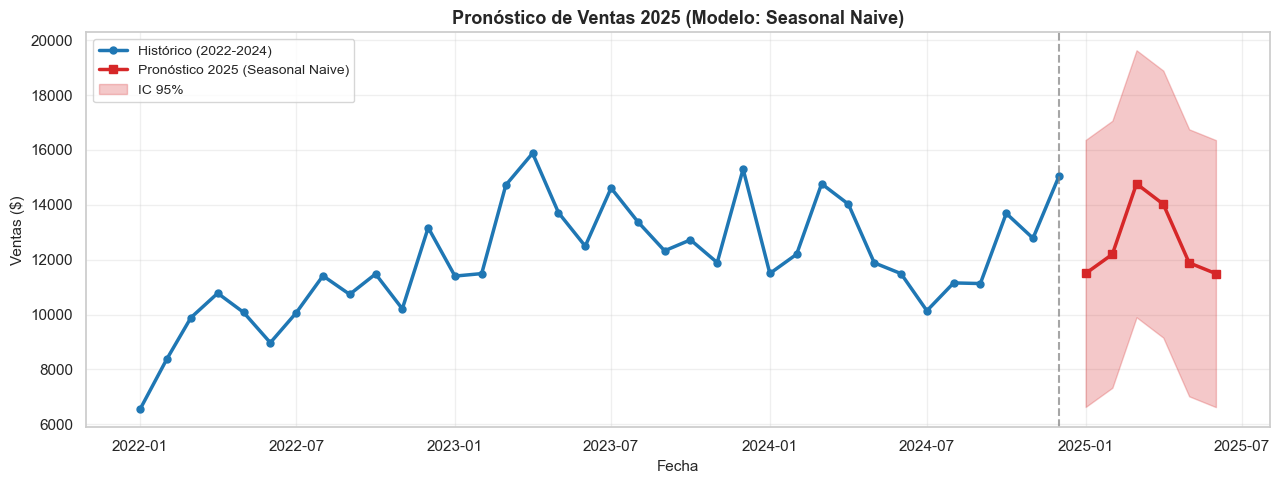

In [14]:
fig, ax = plt.subplots(figsize=(13, 5))

# Serie histórica
ax.plot(y.index, y, marker='o', linewidth=2.5, markersize=5, 
        label='Histórico (2022-2024)', color='#1f77b4')

# Pronóstico
forecast_idx = forecast_table.index
fc_vals = forecast_table['Pronóstico'].values

ax.plot(forecast_idx, fc_vals, marker='s', linewidth=2.5, markersize=6,
        label=f'Pronóstico 2025 ({best_model})', color='#d62728')

# IC (cono de incertidumbre)
ci_lower_vals = forecast_table['IC Inferior'].values
ci_upper_vals = forecast_table['IC Superior'].values

ax.fill_between(forecast_idx, ci_lower_vals, ci_upper_vals,
                 alpha=0.25, color='#d62728', label='IC 95%')

# Línea vertical separadora
ax.axvline(y.index[-1], color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_title(f'Pronóstico de Ventas 2025 (Modelo: {best_model})', 
            fontsize=13, fontweight='bold')
ax.set_xlabel('Fecha', fontsize=11)
ax.set_ylabel('Ventas ($)', fontsize=11)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Análisis de residuos (validación del modelo)

In [15]:
if best_model == 'SARIMA':
    residuals = final_fit.resid
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # 1. Serie de residuos
    axes[0, 0].plot(residuals, linewidth=1.5, color='#1f77b4')
    axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[0, 0].set_title('Residuos en el Tiempo')
    axes[0, 0].set_ylabel('Residuo')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Histograma
    axes[0, 1].hist(residuals, bins=10, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Distribución de Residuos')
    axes[0, 1].set_xlabel('Residuo')
    axes[0, 1].set_ylabel('Frecuencia')
    
    # 3. ACF de residuos
    plot_acf(residuals, lags=15, ax=axes[1, 0])
    axes[1, 0].set_title('ACF de Residuos')
    
    # 4. Q-Q plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot (Normalidad)')
    
    plt.tight_layout()
    plt.show()
    
    # Test de Ljung-Box
    print('\n📊 Test de Ljung-Box (autocorrelación de residuos)')
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    display(lb_test)
    
    print('\n✓ Si p-valor > 0.05 en todos los lags → residuos sin autocorrelación (✓)')
else:
    print(f'\nNota: Análisis de residuos disponible para modelos de statsmodels (SARIMA).')


Nota: Análisis de residuos disponible para modelos de statsmodels (SARIMA).


## Parte 5: Conclusiones y recomendaciones

In [16]:
print("\n" + "="*70)
print("RESUMEN FINAL DEL PROYECTO")
print("="*70)

print(f"\n1. MODELO SELECCIONADO: {best_model}")
print(f"   - RMSE: ${cv_df.loc[best_model, 'RMSE']:.2f}")
print(f"   - MAE: ${cv_df.loc[best_model, 'MAE']:.2f}")
print(f"   - MAPE: {cv_df.loc[best_model, 'MAPE']:.2f}%")

if best_model == 'SARIMA':
    print(f"\n2. ESPECIFICACIÓN DEL MODELO")
    print(f"   SARIMA{order_sarima}x{seasonal_order_sarima}")
    print(f"   - (p,d,q): Componentes AR, diferenciación, MA")
    print(f"   - (P,D,Q,s): Versión estacional (período=12 meses)")

print(f"\n3. PRONÓSTICO 2025 (6 MESES)")
print(f"   Rango estimado: ${forecast_table['IC Inferior'].min():.0f} - ${forecast_table['IC Superior'].max():.0f}")
print(f"   Promedio pronóstico: ${forecast_table['Pronóstico'].mean():.0f}")

print(f"\n4. RECOMENDACIONES")
print(f"   ✓ Monitorear desempeño mensual vs pronóstico")
print(f"   ✓ Recalibrar modelo cada trimestre con datos nuevos")
print(f"   ✓ Investigar anomalías estacionales (ej. campañas, clima)")
print(f"   ✓ Considerar variables exógenas (temperatura real, promociones)")

print(f"\n5. LIMITACIONES")
print(f"   • Dataset pequeño (36 meses)")
print(f"   • Sin variables exógenas (climáticas, comerciales)")
print(f"   • Asume continuidad de patrones históricos")
print(f"   • Sensible a cambios estructurales no anticipados")

print("\n" + "="*70)


RESUMEN FINAL DEL PROYECTO

1. MODELO SELECCIONADO: Seasonal Naive
   - RMSE: $1440.44
   - MAE: $1295.64
   - MAPE: 11.24%

3. PRONÓSTICO 2025 (6 MESES)
   Rango estimado: $6625 - $19633
   Promedio pronóstico: $12644

4. RECOMENDACIONES
   ✓ Monitorear desempeño mensual vs pronóstico
   ✓ Recalibrar modelo cada trimestre con datos nuevos
   ✓ Investigar anomalías estacionales (ej. campañas, clima)
   ✓ Considerar variables exógenas (temperatura real, promociones)

5. LIMITACIONES
   • Dataset pequeño (36 meses)
   • Sin variables exógenas (climáticas, comerciales)
   • Asume continuidad de patrones históricos
   • Sensible a cambios estructurales no anticipados



## Apéndice: Notas técnicas

### SARIMA(p,d,q)(P,D,Q,s)
- **p**: Orden AR (autoregresión)
- **d**: Grado de diferenciación
- **q**: Orden MA (media móvil)
- **P, D, Q**: Versiones estacionales
- **s**: Período estacional (12 para datos mensuales)

### Métricas
- **RMSE** (Root Mean Squared Error): Penaliza errores grandes
- **MAE** (Mean Absolute Error): Interpretación directa en $ del promedio de error
- **MAPE** (Mean Absolute Percentage Error): Métrica relativa (%), independiente de escala

### Validación rolling-origin
Emula despliegue mensual real: entrena con ventana inicial y expande incrementalmente.

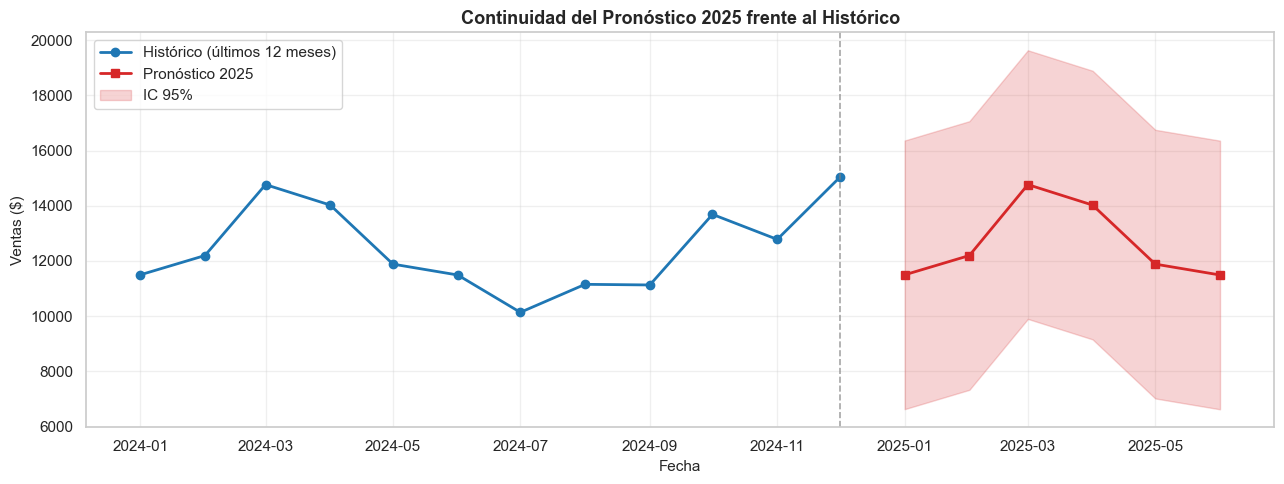

In [17]:
# Plot 1: Continuidad entre histórico y pronóstico (enero–junio 2025)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Asume existencia de variables y (serie histórica) y forecast_table (tabla con Pronóstico e IC)
fig, ax = plt.subplots(figsize=(13, 5))

# Histórico últimos 12 meses
hist_tail = y.iloc[-12:]
ax.plot(hist_tail.index, hist_tail.values, marker='o', linewidth=2.0, label='Histórico (últimos 12 meses)', color='#1f77b4')

# Pronóstico 2025
fc_idx = forecast_table.index
fc_vals = forecast_table['Pronóstico'].values
ax.plot(fc_idx, fc_vals, marker='s', linewidth=2.0, label='Pronóstico 2025', color='#d62728')

# IC
ci_lower_vals = forecast_table['IC Inferior'].values
ci_upper_vals = forecast_table['IC Superior'].values
ax.fill_between(fc_idx, ci_lower_vals, ci_upper_vals, alpha=0.2, color='#d62728', label='IC 95%')

# Línea separadora
ax.axvline(y.index[-1], color='gray', linestyle='--', linewidth=1.2, alpha=0.7)

ax.set_title('Continuidad del Pronóstico 2025 frente al Histórico', fontsize=13, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Ventas ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

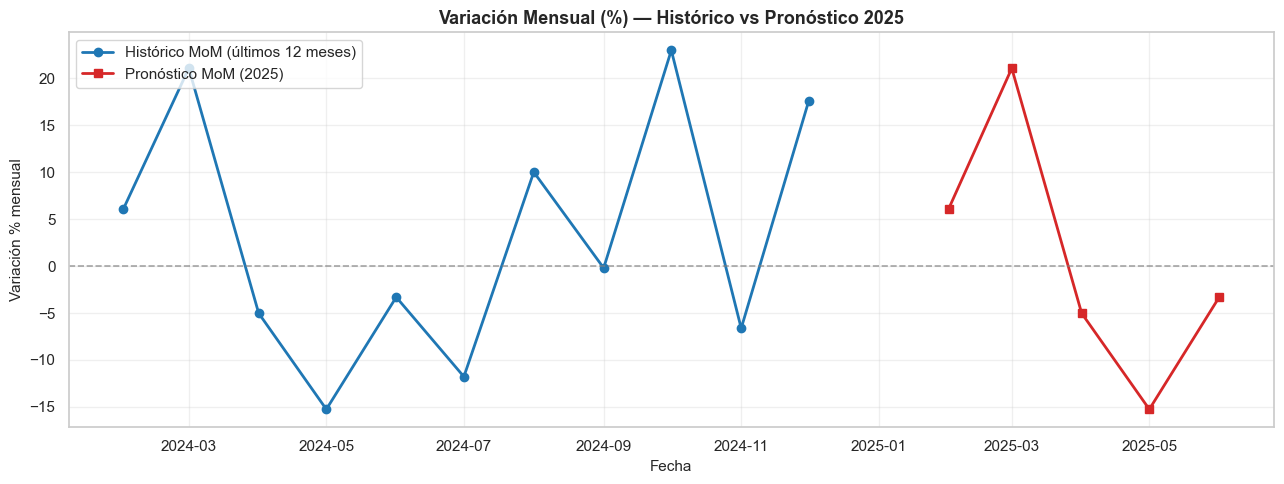

In [18]:
# Plot 2: Variación mensual (MoM) para histórico vs pronóstico
import pandas as pd
import matplotlib.pyplot as plt

# Calcular variación porcentual mensual del histórico (últimos 12 meses)
hist_tail = y.iloc[-12:]
hist_mom = hist_tail.pct_change().multiply(100)

# Variación pronosticada (enero–junio 2025)
fc_series = pd.Series(forecast_table['Pronóstico'].values, index=forecast_table.index)
fc_mom = fc_series.pct_change().multiply(100)

fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(hist_mom.index, hist_mom.values, marker='o', label='Histórico MoM (últimos 12 meses)', color='#1f77b4')
ax.plot(fc_mom.index, fc_mom.values, marker='s', label='Pronóstico MoM (2025)', color='#d62728')
ax.axhline(0, color='gray', linestyle='--', linewidth=1.2, alpha=0.7)
ax.set_title('Variación Mensual (%) — Histórico vs Pronóstico 2025', fontsize=13, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Variación % mensual')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()